In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import scipy.linalg as sp_la

# Data

Today we will keep working with the set of Craigslist listings for used cars.

First I make my converters.

In [4]:
# these will be our columns
columns = ["price", "year", "manufacturer", "model", "condition", "fuel", "odometer", "title_status", "transmission"]
# this will contain our converters
colValues = {}

# first we load our data as strings so we can define the converters
data = np.array(np.genfromtxt('data/vehicles.csv', delimiter=',', usecols=(1,2,3,4,5,7,8,9,11), skip_header=1, dtype=str, encoding='utf-8'))  

# make a list of the unique values in each column of our data
for colIndex in range(data.shape[1]):
    colValues[colIndex] = np.unique(data[:, colIndex]).tolist()

# map values to their indices in the list of unique values
def converter(x, colIndex):
    return colValues[colIndex].index(x)

Then I load the data.

In [5]:
# This dataset is the mazda subsample from https://www.kaggle.com/austinreese/craigslist-carstrucks-data after some cleanup

data = np.array(np.genfromtxt('data/vehicles.csv', delimiter=',', usecols=(1,2,3,4,5,7,8,9,11), converters={3: lambda x: converter(x, 2), 4: lambda x: converter(x, 3), 5: lambda x: converter(x, 4), 7: lambda x: converter(x,5), 9: lambda x: converter(x, 7), 11: lambda x: converter(x, 8)}, skip_header=1, dtype=int, encoding='utf-8'))  

Let's get some summary statistics and do a **pairplot** so we can see what's going on.

In [6]:
def getSummaryStatistics(data):
    print("min, max, mean, std per variable")
    return pd.DataFrame([data.min(axis=0), data.max(axis=0), data.mean(axis=0), data.std(axis=0)])

def getShapeType(data):
    print("shape")
    return (data.shape, data.dtype)

print(getSummaryStatistics(data))
print(getShapeType(data))

min, max, mean, std per variable
              0            1         2           3         4         5  \
0      0.000000  1999.000000  0.000000    0.000000  0.000000  0.000000   
1  55000.000000  2021.000000  1.000000  340.000000  5.000000  4.000000   
2   7978.281507  2012.381887  0.445535  159.225142  1.061431  2.012350   
3   5542.906703     3.997048  0.497025   96.160745  1.225660  0.138432   

              6         7         8  
0  0.000000e+00  0.000000  0.000000  
1  9.999999e+06  5.000000  2.000000  
2  1.124405e+05  0.209943  0.886954  
3  2.546163e+05  0.910812  0.424340  
shape
((3158, 9), dtype('int64'))


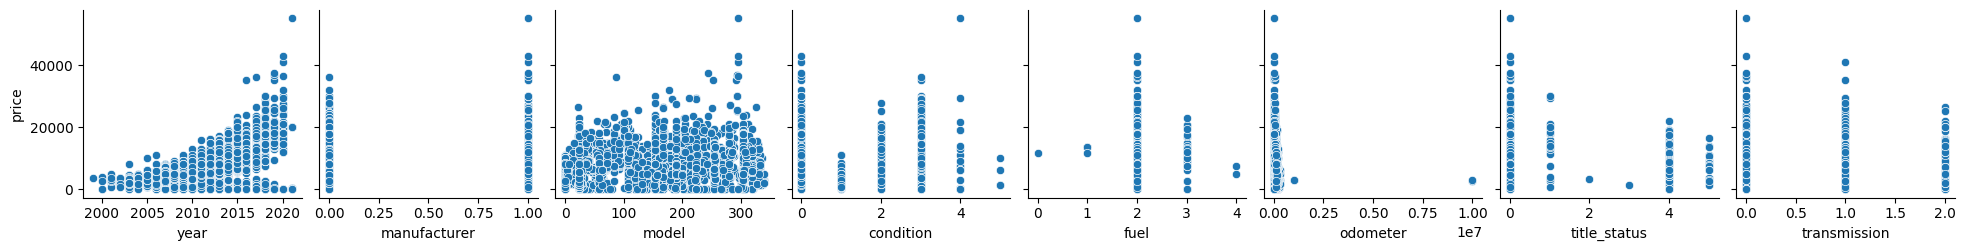

In [7]:
df = pd.DataFrame(data, columns=columns)
seaborn.pairplot(df, y_vars = columns[0], x_vars = columns[1:])

plt.show()

# Let's review regression

Regression allows us to:
* determine the *nature* of a relationship between one (or more!) independent variables and a dependent variable
* determine the *strength* of the relationship

Regression *fits* a function to a dataset.

## What kinds of functions can we fit? 

I want to predict price as a function of the square of age. 

It turns out I can do this using **polynomial regression**. The function I will want to fit will be: $\hat{y} = c_0 + c_1*x + c_2*x^2$, and I do this by minimizing the sum of the squares of the residuals $r_i = y_i - \hat{y_i}$.

In terms of matrix math, for $N$
 data points, $A$
 will just be a matrix of shape ($N, d+1$), where $d$ is the degree of the polynomial and $\vec{c}$ 
 will have shape ($degree, 1$)
 (including $c_0$, the intercept) and $\vec{y}$ will have shape ($N, 1$) (as before). 
 
 **However**, before I calculate the least squares solution, I first have to convert the age variable. For example, let's say I want the square of age: I have to find the square of each year in the year column.

Let's do it! 

### First, split our data

Let's split our data into **train** and **test**. Let's make sure and sort by time first, because we don't want to let the future predict the past.

In [8]:
data = data[data[:, 1].argsort()]
print(getSummaryStatistics(data))
print(getShapeType(data))

(train, test) = np.split(data, [int(len(data) / 10 * 8)])
print(train.shape, test.shape)

min, max, mean, std per variable
              0            1         2           3         4         5  \
0      0.000000  1999.000000  0.000000    0.000000  0.000000  0.000000   
1  55000.000000  2021.000000  1.000000  340.000000  5.000000  4.000000   
2   7978.281507  2012.381887  0.445535  159.225142  1.061431  2.012350   
3   5542.906703     3.997048  0.497025   96.160745  1.225660  0.138432   

              6         7         8  
0  0.000000e+00  0.000000  0.000000  
1  9.999999e+06  5.000000  2.000000  
2  1.124405e+05  0.209943  0.886954  
3  2.546163e+05  0.910812  0.424340  
shape
((3158, 9), dtype('int64'))
(2526, 9) (632, 9)


### Second, compute the polynomial degree of each independent variable.

For example, let's calculate the square of age.

In [9]:
def makePoly(x, poly):
    # make an empty array of size A
    A = np.zeros([x.shape[0], poly+1])
    for i in range(0, poly+1):
        A[:, i] = np.squeeze(x**i)
    print(getSummaryStatistics(A))
    print(getShapeType(A))
    return A

### Third, define updated fit and predict functions that incorporate makePoly

In [10]:
def fit(data, independent, dependent, poly):
    # This is our independent variable, just one for now
    x = data[np.ix_(np.arange(data.shape[0]), independent)]

    # We add a column of 1s for the intercept
    A = makePoly(x, poly)
    # This is the dependent variable 
    y = data[:, dependent]

    # This is the regression coefficients that were fit, plus some other results
    c, _, _, _ = sp_la.lstsq(A, y)
    return c

def predict(data, independent, poly, c):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]

    # We add a column of 1s for the intercept
    A = makePoly(x, poly)

    return np.dot(A, c)

### Fourth, evaluate using $R^2$

In [14]:
def rsquared(y, yhat):
    if len(y) != len(yhat):
        print("Need y and yhat to be the same length!")
        return 0
    return 1 - (((y - yhat)**2).sum() / ((y - y.mean())**2).sum())

In [15]:
c = fit(train, [1], 0, 2)
yhat = predict(test, [1], 2, c)
rsquared(test[:, 0], yhat)

min, max, mean, std per variable
     0            1             2
0  1.0  1999.000000  3.996001e+06
1  1.0  2016.000000  4.064256e+06
2  1.0  2011.077197  4.044443e+06
3  0.0     3.330914  1.339030e+04
shape
((2526, 3), dtype('float64'))
min, max, mean, std per variable
     0            1             2
0  1.0  2016.000000  4.064256e+06
1  1.0  2021.000000  4.084441e+06
2  1.0  2017.596519  4.070697e+06
3  0.0     1.220936  4.927804e+03
shape
((632, 3), dtype('float64'))


0.07479036866672473

Notice this is no longer a line we are plotting!

In [16]:
def plotxyyhat(x, y, c):
    plt.clf()
    plt.plot(x, y, 'o', label='data')
    xCurve = np.linspace(np.min(x), np.max(x))
    yCurve = c[0]
    for i in range(1, len(c)):
        yCurve += c[i]*(xCurve**i)
    plt.plot(xCurve, yCurve, label='least squares fit, y polynomial')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(framealpha=1, shadow=True)
    plt.grid(alpha=0.25)
    plt.show()

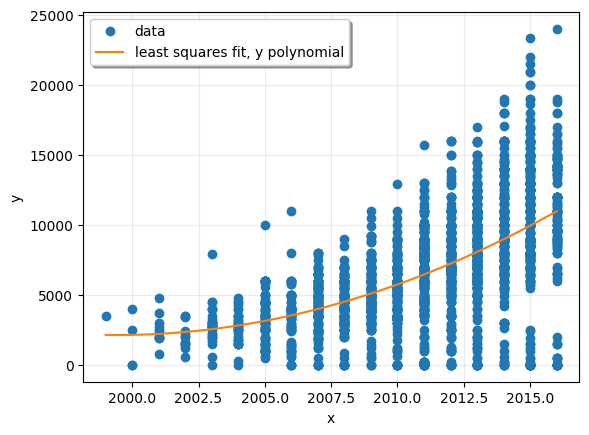

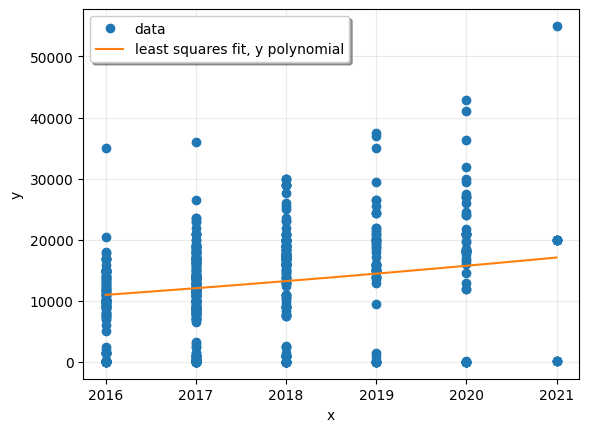

In [17]:
plotxyyhat(train[:, 1], train[:, 0], c)
plotxyyhat(test[:, 1], test[:, 0], c)

### Now let's try a cubic model

$$y = c_0 + c_1x_1 + c_2x_1^2 + c_3x_1^3$$

In [ ]:
c = fit(train, [7], 12, 10)
yhat = predict(test, [7], 10, c)
rsquared(test[:, 12], yhat)

In [ ]:
plotxyyhat(train[:, 7], train[:, 12], c)
plotxyyhat(test[:, 7], test[:, 12], c)